<a href="https://colab.research.google.com/github/yuvipaloozie/CHANA/blob/main/CHANA_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # Cell 1: Colab Setup and Library Imports for Preprocessing

# Install necessary libraries (no need for TensorFlow or segmentation_models here)
!pip install -q scikit-image opencv-python matplotlib pillow
!pip install -q imagecodecs
# Core imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte # For .tif loading and consistent 8-bit conversion
from PIL import Image # Pillow as a fallback for .tif loading

print("Preprocessing environment setup and libraries imported.")

Preprocessing environment setup and libraries imported.


In [ ]:
!pip install -q imagecodecs
import os
import glob
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

# Define the path to your mask images
MASK_IMAGES_PATH = '/content/drive/MyDrive/CHANA_files/mask_images_512'

# Ensure the path exists
if not os.path.exists(MASK_IMAGES_PATH):
    print(f"Error: The directory '{MASK_IMAGES_PATH}' does not exist.")
else:
    mask_files = glob.glob(os.path.join(MASK_IMAGES_PATH, '*.tif')) + \
                 glob.glob(os.path.join(MASK_IMAGES_PATH, '*.png'))

    if not mask_files:
        print("No mask files found in the directory.")
    else:
        imbalance_ratios = []

        print(f"Found {len(mask_files)} mask files. Calculating imbalance ratios...")

        for mask_file in mask_files:
            try:
                mask = io.imread(mask_file)

                # Assume white pixels are > 0
                white_pixels = np.sum(mask > 0)
                total_pixels = mask.size

                if total_pixels > 0:
                    imbalance_ratios.append(white_pixels / total_pixels)
            except Exception as e:
                print(f"Error processing mask {mask_file}: {e}. Skipping this file.")

        # Plot the distribution
        if imbalance_ratios:
            plt.figure(figsize=(10, 6))
            plt.hist(imbalance_ratios, bins=50, edgecolor='black', alpha=0.7)
            plt.title('Distribution of Osteoclast Pixel Imbalance per Mask')
            plt.xlabel('Ratio of Osteoclast (White) Pixels to Total Pixels')
            plt.ylabel('Number of Masks')
            plt.grid(True)
            plt.show()

            # Print some summary statistics
            print("\n--- Imbalance Ratio Summary ---")
            print(f"Average Ratio: {np.mean(imbalance_ratios):.8f}")
            print(f"Median Ratio: {np.median(imbalance_ratios):.8f}")
            print(f"Min Ratio: {np.min(imbalance_ratios):.8f}")
            print(f"Max Ratio: {np.max(imbalance_ratios):.8f}")
            print("-----------------------------")

        else:
            print("No valid ratios to plot.")

No mask files found in the directory.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 2: Define Project Paths and Preprocessing Configuration

# Mount Google Drive to access your raw images and save preprocessed ones
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

# --- IMPORTANT: Adjust this base path to your actual folder on Google Drive ---
PROJECT_BASE_PATH = '/content/drive/MyDrive/CHANA_files'
# Directories for your raw images and where preprocessed images will be saved
RAW_IMAGES_DIR = os.path.join(PROJECT_BASE_PATH, 'original_images')
PREPROCESSED_FOR_ANNOTATION_DIR = os.path.join(PROJECT_BASE_PATH, 'preprocessed_images')

# --- Preprocessing Configuration ---
# This is the size your images will be resized to *before* manual annotation.
# This will also be the input size for your U-Net.
# Adjust this (e.g., to 768, 1024) to retain more nuclei detail based on your visual inspection.
TARGET_ANNOTATION_SIZE = (512,512) # Example: 512x512 pixels (you might increase this)

print(f"Project base path: {PROJECT_BASE_PATH}")
print(f"Raw images source: {RAW_IMAGES_DIR}")
print(f"Preprocessed output: {PREPROCESSED_FOR_ANNOTATION_DIR}")
print(f"Target size for preprocessing: {TARGET_ANNOTATION_SIZE}")

# Create output directory if it doesn't exist (safe to run multiple times)
os.makedirs(PREPROCESSED_FOR_ANNOTATION_DIR, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Project base path: /content/drive/MyDrive/CHANA_files
Raw images source: /content/drive/MyDrive/CHANA_files/original_images
Preprocessed output: /content/drive/MyDrive/CHANA_files/preprocessed_images
Target size for preprocessing: (512, 512)


In [ ]:
# Cell 3: Preprocessing Function and Batch Processing

# --- Preprocessing Function Definition ---
def preprocess_image_for_annotation(image_path, target_size):
    """
    Loads a .tif image, applies channel isolation, denoising, contrast enhancement,
    sharpening, and resizing, preparing it for manual annotation.
    Returns the preprocessed image (NumPy array, uint8, grayscale).
    """
    img_rgb = None
    try:
        # 1. Load the Image (.tif handling using scikit-image)
        img_rgb = io.imread(image_path)
        if img_rgb.ndim == 2: # If grayscale, convert to 3 channels for consistent handling
            img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2BGR)
        elif img_rgb.shape[2] == 4: # If RGBA, drop alpha channel
            img_rgb = img_rgb[:, :, :3]
    except Exception as e:
        print(f"  Error loading {image_path} with skimage: {e}. Trying PIL fallback...")
        try:
            img_pil = Image.open(image_path)
            if img_pil.mode == 'RGBA':
                img_rgb = np.array(img_pil.convert('RGB'))
            else:
                img_rgb = np.array(img_pil.convert('RGB')) # Ensure RGB for consistency
            if img_rgb.ndim == 2:
                img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2BGR)
        except Exception as e_pil:
            print(f"  PIL also failed to load {image_path}: {e_pil}. Skipping this image.")
            return None

    # Ensure image is 8-bit (0-255 range) and suitable for OpenCV processing
    if img_rgb.dtype != np.uint8:
        img_rgb = img_as_ubyte(img_rgb) # Converts to uint8 and scales if needed

    # 2. Color Channel Isolation (Red Channel for TRAP stain)
    # Assuming standard RGB (index 0 for Red). If your image is BGR, it would be index 2.
    # You might want to visually inspect a raw image first to confirm channel order if issues arise.
    red_channel = img_rgb[:, :, 0] # Extract the Red channel

    # 3. Denoising (Non-local Means Denoising)
    # h: filter strength. Adjust this if nuclei are too smooth (reduce h) or too noisy (increase h).
    denoised_image = cv2.fastNlMeansDenoising(red_channel, None, h=10, templateWindowSize=7, searchWindowSize=21)

    # 4. Contrast Enhancement (CLAHE - Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8)) # Adjust clipLimit and tileGridSize if needed
    enhanced_image = clahe.apply(denoised_image)

    # 5. Sharpening
    sharpening_kernel = np.array([[-1, -1, -1],
                                  [-1,  9, -1],
                                  [-1, -1, -1]]) # Standard sharpening kernel
    sharpened_image = cv2.filter2D(enhanced_image, -1, sharpening_kernel)

    # 6. Resizing/Downsampling for annotation (and U-Net input)
    # INTER_AREA is recommended for downsampling to avoid aliasing artifacts.
    final_preprocessed_image = cv2.resize(sharpened_image, target_size, interpolation=cv2.INTER_AREA)

    return final_preprocessed_image

# --- Batch Process All Images ---
print(f"\nStarting preprocessing of images in: {RAW_IMAGES_DIR}")

if not os.path.exists(RAW_IMAGES_DIR):
    print(f"Error: The directory '{RAW_IMAGES_DIR}' was not found. Please check the path and ensure the folder exists on your Google Drive.")
else:
    image_files = [f for f in os.listdir(RAW_IMAGES_DIR) if f.lower().endswith(('.tif', '.tiff'))]

    if not image_files:
        print(f"Error: No .tif/.tiff files found in '{RAW_IMAGES_DIR}'. Please ensure your images are uploaded.")
    else:
        for filename in image_files:
            image_path = os.path.join(RAW_IMAGES_DIR, filename)
            # Output filename will be .png for easier handling later
            output_filename = os.path.splitext(filename)[0] + '.png'
            output_path = os.path.join(PREPROCESSED_FOR_ANNOTATION_DIR, output_filename)

            print(f"  Processing {filename}...")
            preprocessed_img = preprocess_image_for_annotation(image_path, TARGET_ANNOTATION_SIZE)

            if preprocessed_img is not None:
                # Save the preprocessed image (as grayscale PNG) to Google Drive
                # This will overwrite existing files with the same name.
                cv2.imwrite(output_path, preprocessed_img)
                print(f"  Saved preprocessed image to {output_path}")
            else:
                print(f"  Failed to preprocess {filename}. Skipping save.")

    print(f"\nAll eligible raw images preprocessed and saved to {PREPROCESSED_FOR_ANNOTATION_DIR} for manual annotation.")


Starting preprocessing of images in: /content/drive/MyDrive/CHANA_files/original_images
  Processing Copy of 700cell_Rank100_VIMU6_G4_Tile_74.tif...
  Saved preprocessed image to /content/drive/MyDrive/CHANA_files/preprocessed_images/Copy of 700cell_Rank100_VIMU6_G4_Tile_74.png
  Processing 800cell 75RANKL W5.jpg_Tile_19.tif...
  Saved preprocessed image to /content/drive/MyDrive/CHANA_files/preprocessed_images/800cell 75RANKL W5.jpg_Tile_19.png
  Processing 800cell 75RANKL W5.jpg_Tile_18.tif...
  Saved preprocessed image to /content/drive/MyDrive/CHANA_files/preprocessed_images/800cell 75RANKL W5.jpg_Tile_18.png
  Processing Copy of 700cell_Rank100_VIMU6_G4_Tile_76.tif...
  Saved preprocessed image to /content/drive/MyDrive/CHANA_files/preprocessed_images/Copy of 700cell_Rank100_VIMU6_G4_Tile_76.png
  Processing 800cell 75RANKL W5.jpg_Tile_56.tif...
  Saved preprocessed image to /content/drive/MyDrive/CHANA_files/preprocessed_images/800cell 75RANKL W5.jpg_Tile_56.png
  Processing Cop

--- Displaying Sample Original vs. Preprocessed Image Pairs ---


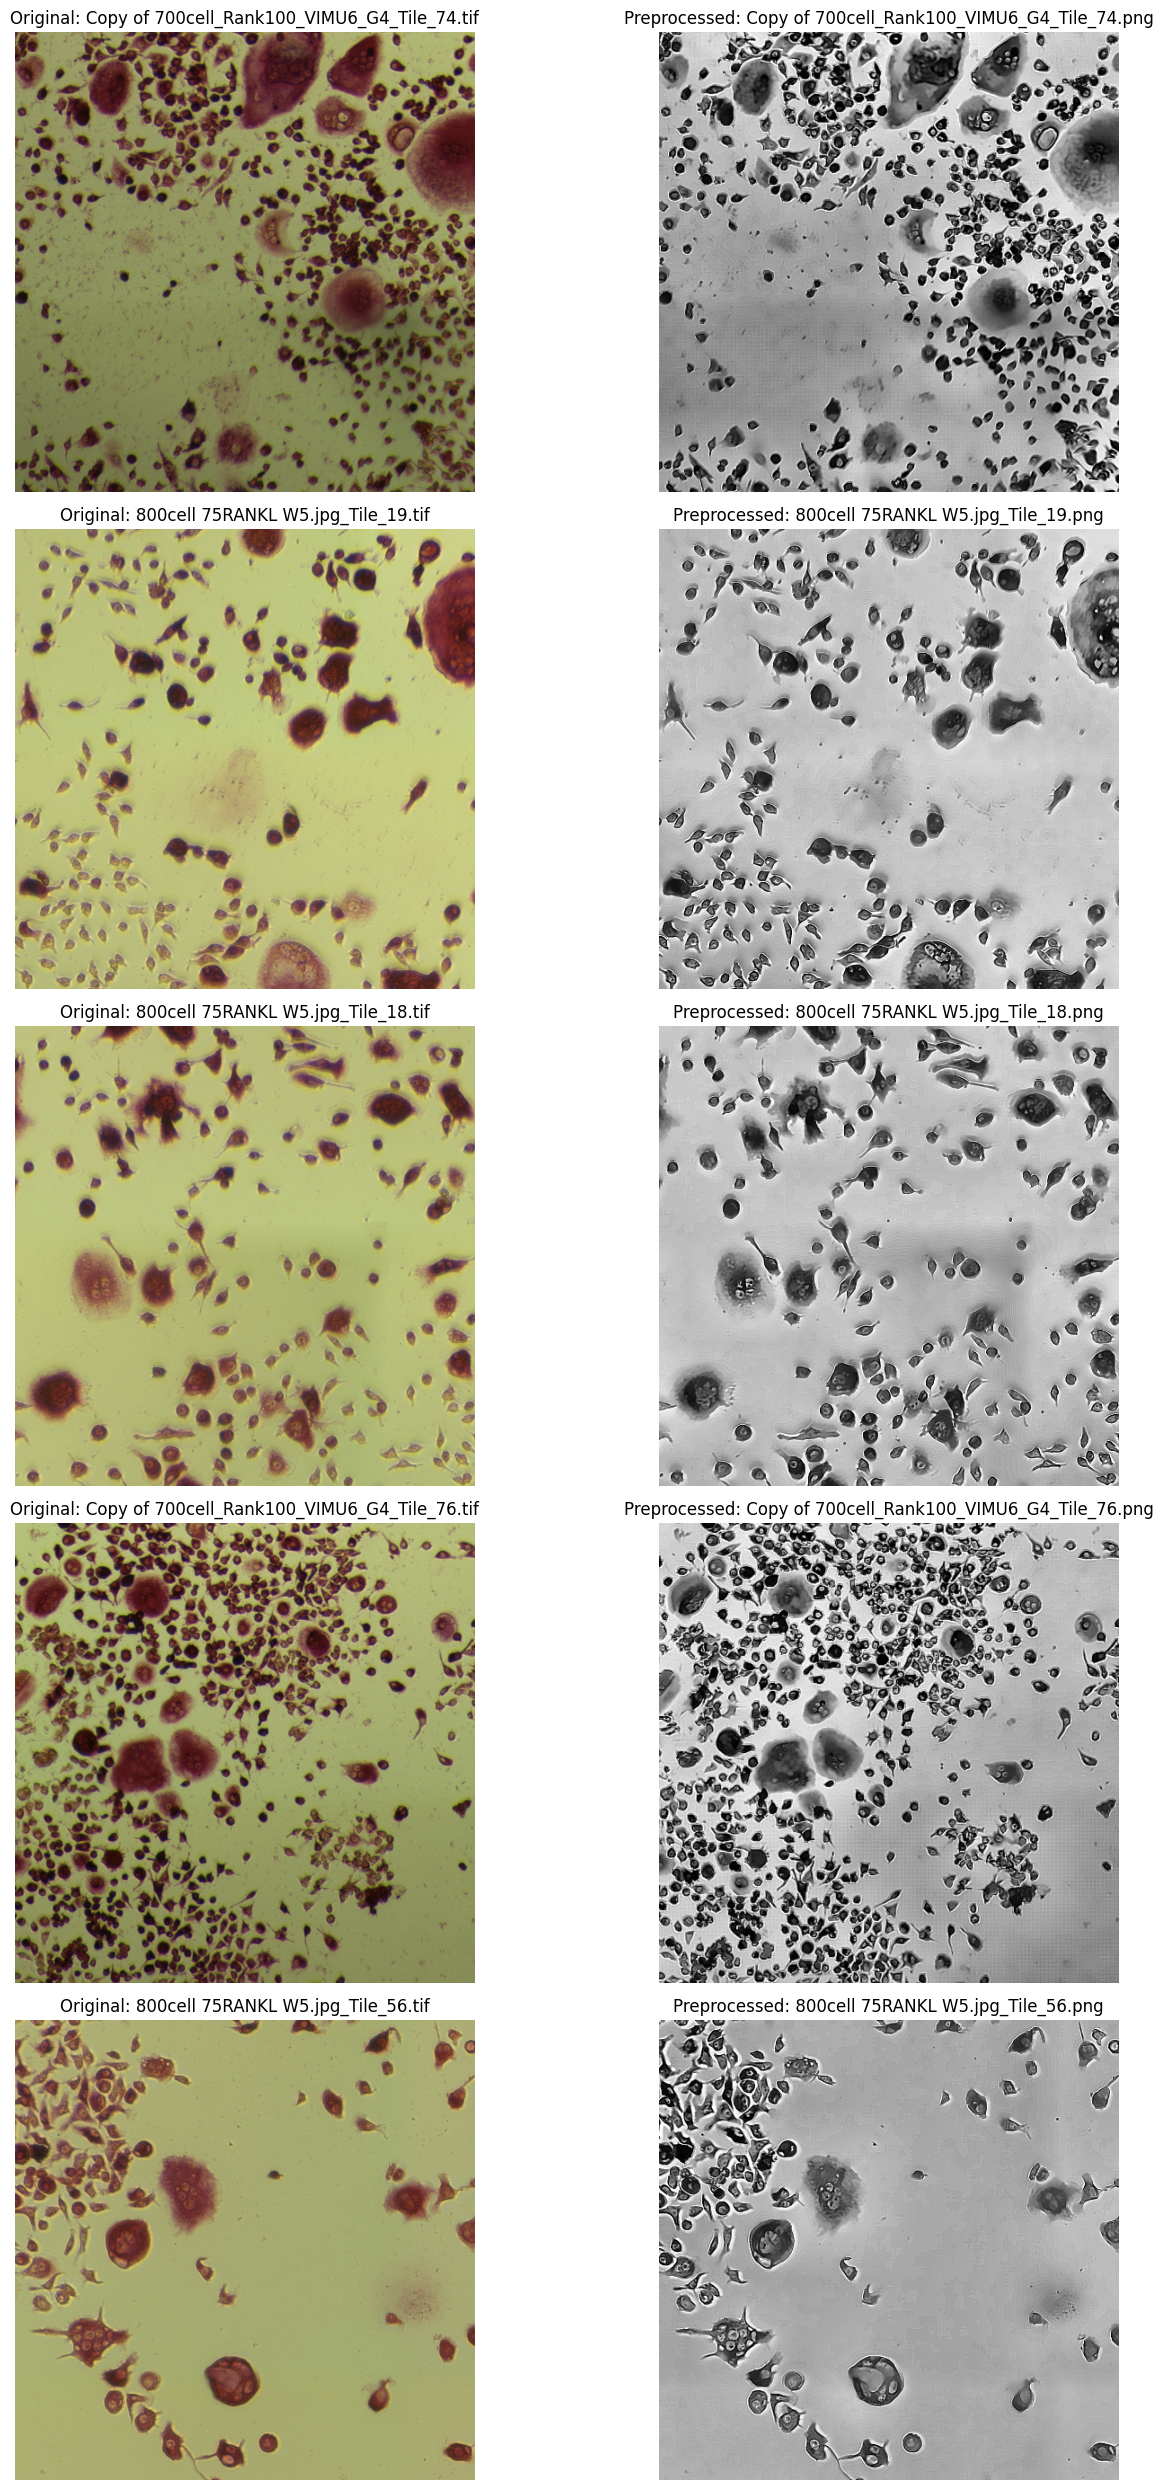

In [ ]:
# Cell 4: Visual Verification of Preprocessing Output

print("--- Displaying Sample Original vs. Preprocessed Image Pairs ---")

# Get list of preprocessed PNG files
preprocessed_files = [f for f in os.listdir(PREPROCESSED_FOR_ANNOTATION_DIR) if f.lower().endswith('.png')]

num_display_pairs = min(5, len(preprocessed_files)) # Display up to 3 pairs

if num_display_pairs == 0:
    print("No preprocessed images found for display. Ensure Cell 3 was run successfully.")
else:
    plt.figure(figsize=(15, num_display_pairs * 5)) # Adjust figure size

    displayed_count = 0
    for preprocessed_filename in preprocessed_files:
        if displayed_count >= num_display_pairs:
            break

        base_filename = os.path.splitext(preprocessed_filename)[0]

        # Try to find original .tif or .tiff
        original_tif_path = os.path.join(RAW_IMAGES_DIR, base_filename + '.tif')
        if not os.path.exists(original_tif_path):
            original_tif_path = os.path.join(RAW_IMAGES_DIR, base_filename + '.tiff')

        preprocessed_png_path = os.path.join(PREPROCESSED_FOR_ANNOTATION_DIR, preprocessed_filename)

        # Load original .tif image (as RGB for display)
        original_img_display = None
        try:
            original_img = io.imread(original_tif_path)
            if original_img.ndim == 2: original_img_display = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)
            elif original_img.shape[2] == 4: original_img_display = original_img[:, :, :3]
            else: original_img_display = original_img
        except Exception as e:
            print(f"  Error loading original {original_tif_path} for display: {e}")

        # Load preprocessed .png image (as grayscale)
        preprocessed_img_loaded = cv2.imread(preprocessed_png_path, cv2.IMREAD_GRAYSCALE)

        if original_img_display is None or preprocessed_img_loaded is None:
            print(f"  Skipping display for {base_filename} due to loading issues.")
            continue

        # Display the pair
        plt.subplot(num_display_pairs, 2, displayed_count * 2 + 1)
        plt.imshow(original_img_display)
        plt.title(f"Original: {base_filename}.tif")
        plt.axis('off')

        plt.subplot(num_display_pairs, 2, displayed_count * 2 + 2)
        plt.imshow(preprocessed_img_loaded, cmap='gray') # Preprocessed image is grayscale
        plt.title(f"Preprocessed: {base_filename}.png")
        plt.axis('off')

        displayed_count += 1

    plt.tight_layout()
    plt.show()

In [ ]:
import os
import cv2
from skimage import io # For reading .tif files
import numpy as np
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')
print("Google Drive mounted.")

# 2. Define File Paths and Sizes
PROJECT_BASE_PATH = '/content/drive/MyDrive/CHANA_files'
SOURCE_MASKS_DIR = os.path.join(PROJECT_BASE_PATH, 'mask_images')
DESTINATION_MASKS_DIR = os.path.join(PROJECT_BASE_PATH, 'mask_images_512')

# Create the destination directory if it doesn't exist
os.makedirs(DESTINATION_MASKS_DIR, exist_ok=True)

TARGET_SIZE = (512, 512)
print(f"Downsampling masks to {TARGET_SIZE[0]}x{TARGET_SIZE[1]} pixels.")


# 3. Loop Through Masks, Resize, and Save
print("\nStarting mask downsampling...")
mask_files = sorted([f for f in os.listdir(SOURCE_MASKS_DIR) if f.lower().endswith(('.tif', '.tiff'))])
if not mask_files:
    print(f"Error: No .tif/.tiff files found in {SOURCE_MASKS_DIR}. Please check the folder.")
else:
    for filename in mask_files:
        src_path = os.path.join(SOURCE_MASKS_DIR, filename)
        dest_path = os.path.join(DESTINATION_MASKS_DIR, filename)

        try:
            # Load the mask (skimage.io is good for .tif)
            mask_orig = io.imread(src_path)

            # Resize the mask using nearest-neighbor interpolation to preserve pixel values (0 or 255)
            # This is CRUCIAL for binary masks!
            mask_resized = cv2.resize(mask_orig, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)

            # Save the resized mask as a new .tif file
            cv2.imwrite(dest_path, mask_resized)
            print(f"  Successfully downsampled and saved {filename} to {DESTINATION_MASKS_DIR}.")

        except Exception as e:
            print(f"  ERROR processing {filename}: {e}. Skipping.")

print("\nMask downsampling script complete.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.
Downsampling masks to 512x512 pixels.

Starting mask downsampling...
  Successfully downsampled and saved 1500cell_100RANK C5_2_mask.tif to /content/drive/MyDrive/CHANA_files/mask_images_512.
  Successfully downsampled and saved 1500cell_100RANK _C4_1_mask.tif to /content/drive/MyDrive/CHANA_files/mask_images_512.
  Successfully downsampled and saved 1500cell_100RANK _C4_2_mask.tif to /content/drive/MyDrive/CHANA_files/mask_images_512.
  Successfully downsampled and saved 1500cell_100RANK_C4_3_mask.tif to /content/drive/MyDrive/CHANA_files/mask_images_512.
  Successfully downsampled and saved 1500cell_100RANK_C5_1_mask.tif to /content/drive/MyDrive/CHANA_files/mask_images_512.
  Successfully downsampled and saved 1500cell_100RANK_C5_3_mask.tif to /content/drive/MyDrive/CHANA_files/mask_images_512.
  Successfully downsampled and saved 150

In [ ]:
# --- NEW CELL ---
# Cell 3: Verify File Counts in Key Directories

print("\n--- Verifying File Counts in Key Data Directories ---")

# Define the folders to check (using paths defined in Cell 2)
folders_to_check = {
    "Raw Images (original_images)": RAW_IMAGES_DIR,
    "Raw Masks (raw_masks)": SOURCE_MASKS_DIR,
    "Preprocessed Images (preprocessed_images)": PREPROCESSED_FOR_ANNOTATION_DIR,
    "Processed Masks (mask_images_512)": DESTINATION_MASKS_DIR
}

# Common image/mask extensions to count
image_extensions = ('.tif', '.tiff', '.TIF', '.TIFF', '.png')

for folder_name, folder_path in folders_to_check.items():
    count = 0
    if os.path.exists(folder_path):
        for fname in os.listdir(folder_path):
            if fname.lower().endswith(image_extensions):
                count += 1
        print(f"  {folder_name}: {count} files found.")
    else:
        print(f"  {folder_name}: Directory '{folder_path}' does NOT exist.")

print("--- File Count Verification Complete ---")


--- Verifying File Counts in Key Data Directories ---
  Raw Images (original_images): 1017 files found.
  Raw Masks (raw_masks): 988 files found.
  Preprocessed Images (preprocessed_images): 1017 files found.
  Processed Masks (mask_images_512): 988 files found.
--- File Count Verification Complete ---


In [ ]:
# Cell X: Analyze and Count Osteoclasts in Ground Truth Masks

# Ensure imagecodecs is installed for LZW compressed TIFF files
!pip install -q imagecodecs

import os
import numpy as np
import pandas as pd
from skimage import io, measure

# --- Configuration ---
# Set the project path based on your setup
PROJECT_BASE_PATH = '/content/drive/MyDrive/CHANA_files'
GROUND_TRUTH_MASKS_DIR = os.path.join(PROJECT_BASE_PATH, 'mask_images_512')

# Define the area thresholds for what constitutes an osteoclast
MIN_OSTEO_AREA_PIXELS = 25
MAX_OSTEO_AREA_PIXELS = 100000000

print("Starting analysis of ground truth masks for osteoclast counts...")

mask_files = sorted([f for f in os.listdir(GROUND_TRUTH_MASKS_DIR) if f.lower().endswith('.tif')])

if not mask_files:
    print(f"No mask files found in '{GROUND_TRUTH_MASKS_DIR}'. Please check the path and file extensions.")
else:
    results_list = []

    for mask_filename in mask_files:
        mask_path = os.path.join(GROUND_TRUTH_MASKS_DIR, mask_filename)

        try:
            # Load the mask
            mask_data = io.imread(mask_path)

            # The mask should already be binary (0 or 255), but we ensure it's a binary array
            binary_mask = (mask_data > 0.5).astype(np.uint8)

            # Label connected components
            labeled_mask, num_labels = measure.label(binary_mask, connectivity=2, return_num=True)

            # Count regions that fall within the specified area thresholds
            osteoclast_count = 0
            for region in measure.regionprops(labeled_mask):
                if region.label == 0: continue
                if MIN_OSTEO_AREA_PIXELS < region.area < MAX_OSTEO_AREA_PIXELS:
                    osteoclast_count += 1

            # Store the result
            results_list.append({
                'filename': mask_filename,
                'osteoclast_count': osteoclast_count
            })

        except Exception as e:
            print(f"Error processing mask {mask_filename}: {e}. Skipping.")

    # Create and display the DataFrame
    if results_list:
        df_counts = pd.DataFrame(results_list)
        print("\nGround Truth Osteoclast Counts:")
        print(df_counts)
        print(f"\nAnalysis complete. Total masks processed: {len(results_list)}")

        # --- NEW LINES TO EXPORT TO CSV ---
        csv_output_path = os.path.join(PROJECT_BASE_PATH, 'ground_truth_osteoclast_counts.csv')
        df_counts.to_csv(csv_output_path, index=False)
        print(f"\nDataFrame successfully saved to CSV at: {csv_output_path}")

Starting analysis of ground truth masks for osteoclast counts...
